# Data visualization for profile interpretation
Written by: Amanda Ng R.H.
<br>Language: `python3`
<br>Created on: 24 Apr 2023
<br>Last updated on: 21 Sep 2023
<br>Prior data processing: Required (📜 3a_execute_distanceCalculation.sh and 📔 3b_ProfileCalculations.ipynb)
<br>Documentation status: In progress ([Sphinx documentation style](https://sphinx-rtd-tutorial.readthedocs.io/en/latest/docstrings.html))

The calculations for profile interpretation were carried out in 📜 3a_execute_distanceCalculation.sh and 📔 3b_ProfileCalculations.ipynb.

## Import packages & custom modules

In [1]:
# File management
import os

# DataFrame management
import pandas as pd
import openpyxl

# Manging static plots
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import collections
from matplotlib.patches import Patch

# Annotating seaborn plots with significance testing results
from statannotations.Annotator import Annotator

# Color management
import matplotlib.colors as mc
import colorsys

# UMAP reduction
from umap import UMAP

# Other math and statistics
from numpy.linalg import norm
import random
import numpy as np
from scipy.stats import mannwhitneyu

# Network graph management
import networkx as nx

/research/lab_winter/users/ang/personal_miniconda_setup/miniconda3/envs/isogenicCPA_jupyterlab/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/research/lab_winter/users/ang/personal_miniconda_setup/miniconda3/envs/isogenicCPA_jupyterlab/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-beh

In [2]:
# Add the paths to the modules to where python will search for modules
import sys
root = "/research/lab_winter/users/ang"
module_paths = [
    f"{root}/isogenicCPA_repo/2_feature_analysis"
]
for module_path in module_paths:
    sys.path.insert(0, module_path)

from general_modules import *
from profile_interpretation_modules import *

## Setting up

In [3]:
######################################################################################
# Paths to the relevant files and directories prior or unrelated to feature extraction
######################################################################################
# Path to the parent direcotry with all the data for the experiment
parent_dir = "/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa"

# Path to the drug metadata sheet
drugMetadata_path = f"{parent_dir}/drug_metadata_sheet.csv"

# Path to the FP assay data
fp_path = f"{parent_dir}/20220923_FP_CRBNbinding.xlsx"

###########################################################################################
# Paths to the relevant files and directories from QC, Profile Assembly & Feature Selection
###########################################################################################
# Path to the directory for Section 2
section2_dir = f"{parent_dir}/cleanPostFeatureExtraction/output_dir/2_ProfileAssemblyAndFeatureSelection_output"

# Path to the morphology profile after robust Z standardization and baseline feature selection
profile_path = f"{section2_dir}/baseline_output.csv"

# Path to the features selected
selectedFeatures_path = f"{section2_dir}/featuresSelected_output.csv"

# Path to the tau output calculated
tauOutput_path = f"{section2_dir}/tau_output.csv"

###########################################
# Path to the profile calculations in julia
###########################################
reducedProfile_path = f"{parent_dir}/cleanPostFeatureExtraction/output_dir/3_ProfileInterpretation_output/BioProfiling_output/umapReducedProfile_c662_rko_wt_global_c662_rko_wt.csv"

dmsoDistance_path = f"{parent_dir}/cleanPostFeatureExtraction/output_dir/3_ProfileInterpretation_output/BioProfiling_output/distance_c662_rko_wt_global_c662_rko_wt_DMSO.csv"

############################################
# Path to the profile calculations in python
############################################
# Path to the directory with the python calculations for profile interpretation
section3_python_dir = f"{parent_dir}/cleanPostFeatureExtraction/output_dir/3_ProfileInterpretation_output/Python_calculations"

# Path to the induction scores calculated
inductionScores_path = f"{section3_python_dir}/inductionScores.csv"

# Path to the corrected U scores calculated
correctedU_path = f"{section3_python_dir}/correctedU.csv"

##########################################
# Path to the output directory and make it
##########################################
output_dir = f"{parent_dir}/cleanPostFeatureExtraction/output_dir/4_ProfileInterpretation_output"
makeDirectory(output_dir)

# Path to save the compound data to
compoundData_path = f"{output_dir}/compoundData.csv"

The following directory already exists:
/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa/cleanPostFeatureExtraction/output_dir/4_ProfileInterpretation_output


## Figure prep set up

In [4]:
# Setting the dictionary to use for the compound types used in the isogenic CPA
label2color_dict = {
    "CRBN-dependent" : "#67E0E6",   # blue
    "CRBN-independent" : "#E68073", # pink
    "Morphological" : "#E6BC70",    # brown
    "CRBN binder" : "#E2E5DE"        # light grey
}

In [5]:
# Define the example compounds and their colors
cpaExamples = {
    "FK-866" : label2color_dict["Morphological"],
    "TL 13-12" : label2color_dict["CRBN-dependent"],
    "Pomalidomide" : "#D048D6" # purple
}

## Data aggregation

In [4]:
def aggregateCalculations(
    drugMetadata = pd.read_csv(drugMetadata_path),
    correctedU = pd.read_csv(correctedU_path),
    dmsoDistance = pd.read_csv(dmsoDistance_path),
    selectedFeatures = pd.read_csv(selectedFeatures_path),
    fp_path = fp_path,
    output_path = compoundData_path
):
    ##############################################################################
    # Rename the CRBN binders (so that the fluorosulfate scaffold is more obvious)
    ##############################################################################
    # Dictionary for mapping the original fluorosulfate scaffold name to the new name
    old2newScaffold_dict = {
        "B" : "FL1",
        "D" : "FL2",
        "F" : "FL3",
        "H" : "FL4",
        "C" : "FL5",
        "E" : "FL6"
    }

    # Create a new column for the compound names
    # and labels that will be used for plotting purposes
    for i in compoundData.index:
        crbnDependency = compoundData.loc[i, "CRBN_dependency"]
        moa_type = compoundData.loc[i, "moa_type"]
        compound = compoundData.loc[i, "Actual name"]
        if moa_type == "unknown" and len(compound) < 4:
            scaffold = compound[0]
            tailGroup = compound[1:]
            newScaffold = old2newScaffold_dict[scaffold]
            newName = f"{newScaffold}-{tailGroup}"
            compoundData.loc[i, "Compound"] = newName
            compoundData.loc[i, "Label"] = "CRBN binder"
        else:
            compoundData.loc[i, "Compound"] = compound
            if crbnDependency == 1:
                compoundData.loc[i, "Label"] = "CRBN-dependent"
            elif crbnDependency == 0:
                if moa_type == "morphology control":
                    compoundData.loc[i, "Label"] = "Morphological"
                else:
                    compoundData.loc[i, "Label"] = "CRBN-independent"

    # Drop any rows which do not have a label
    compoundData = compoundData[~compoundData["Label"].isnull()]
                

    # Make the "Compound" column the first column
    columnOrder = ["Compound", "Label"] + list(drugMetadata.columns)
    compoundData = compoundData[columnOrder]

    ##########################
    # Add in the FP assay data
    ##########################
    # Convert the FP assay data into a dictionary for mapping
    # the treatments to their FP assay results
    treatment2binding_dict = dict()
    fp = pd.read_excel(
        fp_path,
        index_col = 0,
        header = 3
    )
    for prefix in fp.columns:
        for number in fp.index:
            treatment = prefix + str(number)
            binding = fp.loc[number, prefix]
            treatment2binding_dict[treatment] = binding
    
    # Map the FP data to the treatments in the treatmentCalculations
    compoundData["FP_CRBN_binding"] = compoundData["Actual name"].map(treatment2binding_dict)

    ################################################
    # Add in the morphological perturbation strength
    ################################################
    compoundData = pd.merge(
        compoundData,
        dmsoDistance[["Condition", "Distance"]],
        left_on = ["Actual name"],
        right_on = ["Condition"],
        how = "left"
    )

    ################################################################
    # Add the number of treatment-centric features for each compound
    ################################################################
    compoundData = pd.merge(
        compoundData,
        selectedFeatures[["Treatment", "Number_Features"]],
        left_on = "Actual name",
        right_on = "Treatment",
        how = "left"
    )
    
    # Fill the Number_Features to ensure that there are no NaN values
    compoundData["Number_Features"] = compoundData["Number_Features"].fillna(0)

    ############################################################
    # Add in the corrected U scores calculated and their p-value
    ############################################################
    compoundData = pd.merge(
        compoundData,
        correctedU,
        left_on = ["Actual name"],
        right_on = ["Metadata_Treatment"],
        how = "left"
    )

    ##############################
    # Drop the unnecessary columns
    ##############################
    columndToDrop = [
        "Actual name",
        "moa_type",
        "CRBN_interaction",
        "CRBN_dependency",
        "Group",
        "Transfer vol. (nL)",
        "Source conc. (mM)",
        "Synonym(s)",
        "Condition",
        "Metadata_Treatment",
        "Treatment"
    ]
    compoundData = compoundData.drop(columns = columndToDrop)

    ##########################
    # Export the compound data
    ##########################
    compoundData.to_csv(output_path, index = False)
    print(f"EXPORTED: Compound data exported at\n{output_path}")
    
    # Report the number of treatments retained
    print(f"Number of treatments/compounds: {len(compoundData)}")
    
    # Have a look at how the aggregated calculations look like
    print("Preview of five random rows from the compound data:")
    display(compoundData.sample(n = 5))
    
    return

aggregateCalculations()

EXPORTED: Compound data exported at
/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa/cleanPostFeatureExtraction/output_dir/4_ProfileInterpretation_output/compoundData.csv
Number of treatments/compounds: 151
Preview of five random rows from the compound data:


/tmp/ipykernel_580845/4045181631.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compoundData.loc[i, "Compound"] = compound
/tmp/ipykernel_580845/4045181631.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compoundData.loc[i, "Label"] = "Morphological"


,Compound,Label,Treatment conc. (microM),FP_CRBN_binding,Distance,Number_Features,Corrected_u,p-value
113,FL5-5,CRBN binder,10,0.829,0.138636,1.0,0.5400,0.337507
51,FL2-6,CRBN binder,10,4.223,0.247637,0.0,NaN,NaN
89,FL4-2,CRBN binder,10,0.557,0.784366,8.0,0.7875,0.000977
124,FL5-16,CRBN binder,10,4.216,0.236154,0.0,NaN,NaN
134,FL6-5,CRBN binder,10,0.679,0.580972,0.0,NaN,NaN


## 4.1| Profile interpretations using the "global" features and the RKO WT data

### Quality check on the CPA data using "global" strategy
I carried out two feature selection strategies namely "global" for RKO WT and "treatment-centric". The "global" strategy compares features from all treatments. It is typically used in analysis for cell morphological profiling data. In this sub-section, I'll carry out some of the general data visualizations/interpretations used.

I'll start with checking the morphology and the DMSO controls. These controls are present across all plates and should NOT differ drastically if the robust Z standardization (i.e. spherical transformation) was sufficient to negate plate effects (complete negation is not necessary).

The morphology controls I've used are recommended by the [Cell Painting-JUMP consortium](https://github.com/jump-cellpainting/JUMP-Target). AMG-900 is excluded from morphological profile assembly as it causes cells to have multiple nuclei (which cannot be handled by the profile assembly approach). The remaining controls can be split into strong and mild morphology perturbers.

TC-S-7004, FK-866, NVS-PAK-1 and LY2109761 are strong morphology perturbers, while Quinidine, Aloxistatin and Dexamethasone are mild morphology perturbers.

In my experience, strong morphology perturbers form tight clusters which tend to be distinct from that of DMSO controls on 2D UMAPs. Mild morphology perturbers form looser clusters that tend to overlap with DMSO controls on 2D UMAP. The intuition is strong morphology perturbers induce a morphology that isn't usually observed in untreated cells, while mild morphology perturbers shift the distribution of morphology observed in untreated cells toward certain morphology/ies.

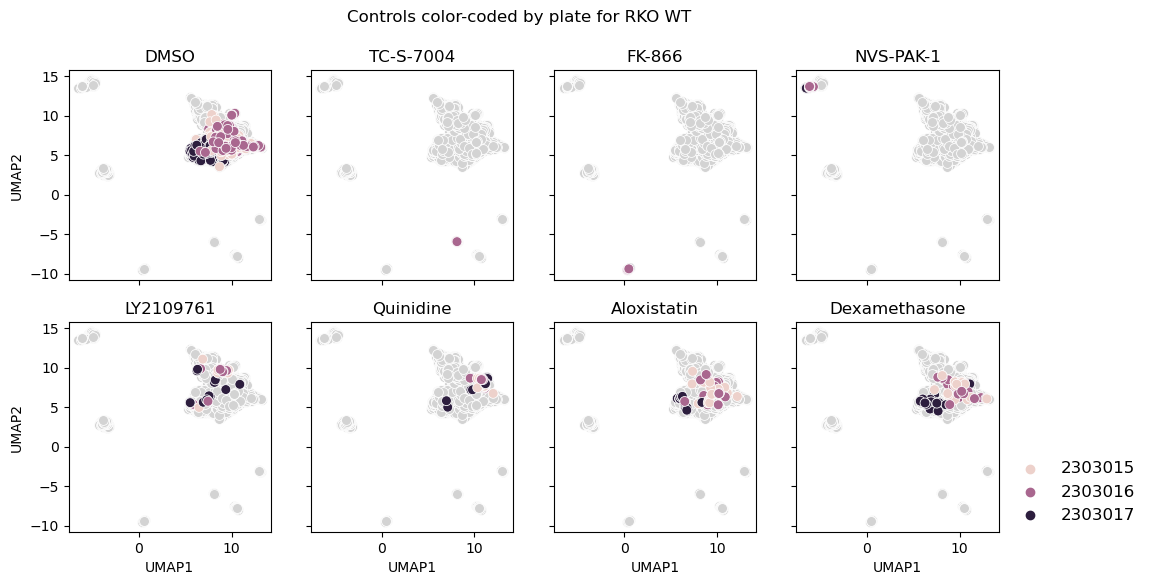

In [5]:
def visualize_UMAPforTreatmentByPlate(
    compounds = [
        "DMSO",
        "TC-S-7004",
        "FK-866",
        "NVS-PAK-1",
        "LY2109761",
        "Quinidine",
        "Aloxistatin",
        "Dexamethasone"
    ],
    profile = pd.read_csv(profile_path),
    selectedFeatures = pd.read_csv(selectedFeatures_path),
    cell = "c662_rko_wt",
    output_path = "",
    suptitle = "Controls color-coded by plate for RKO WT",
    fontsize = 12,
    markerSize = 50,
    labelColor = "black",
    nrows = 2,
    figsize = (12, 6)
):
    # Trim down the profile to the relevant cell line
    profile = profile[profile["Metadata_Cell"] == cell].reset_index(drop = True)
    
    # Retrieve the features selected for the given cell line using the global selection strategy
    features = selectedFeatures[selectedFeatures["Selection_Strategy"] == f"global_{cell}"].reset_index(drop = True)
    features = features.loc[0, "Features_Selected"]
    features = features.split(" ")
    
    # Reduce the profile to 2 UMAP dimensions using 
    reducer = UMAP()
    matrix = profile[features].values
    embedding = reducer.fit_transform(matrix)
    embedding = pd.DataFrame(embedding, columns = ["UMAP1", "UMAP2"])
    reducedProfile = profile[["Metadata_Treatment", "Metadata_Cell", "UpdatedImageNumber", "Metadata_Plate"]].copy(deep = True)
    reducedProfile = pd.concat([reducedProfile, embedding], axis = 1)
    
    # Set the format of the subplots and the figsize
    ncols = int(len(compounds)/nrows)
    fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = figsize)
    
    # For each compound provided by the user
    for i, compound in enumerate(compounds):
        
        # Track which subplot axes to use
        rowPosition = 0
        colPosition = i
        if i + 1> ncols:
            rowPosition += 1
            colPosition = i - rowPosition*ncols
        
        # Trim the redcuedProfile to just one compound
        compound_reducedProfile = reducedProfile[reducedProfile["Metadata_Treatment"] == compound].reset_index(drop = True)

        # Plot the data related to the compound as colored points over a backdrop of grey points
        # which constitutes the remaining compounds that are not part of the subset
        p = sns.scatterplot(
            ax = axes[rowPosition, colPosition],
            data = reducedProfile,
            x = "UMAP1",
            y = "UMAP2",
            color = "lightgrey",
            s = markerSize
        )
        p = sns.scatterplot(
            ax = axes[rowPosition, colPosition],
            data = compound_reducedProfile,
            x = "UMAP1",
            y = "UMAP2",
            hue = "Metadata_Plate",
            s = markerSize
        )
        
        # Set the plot title
        axes[rowPosition, colPosition].set_title(compound, fontsize = fontsize, color = labelColor)

        # Aesthetics to suit a black background
        p.tick_params(color = labelColor, labelcolor = labelColor)
        for spine in p.spines.values():
            spine.set_edgecolor(labelColor)
            
    # Set the shared legend
    handles, labels = axes[rowPosition, colPosition].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        # title = "Plate ID",
        # title_fontsize = fontsize,
        loc = "lower left",
        bbox_to_anchor = (0.9, 0.1), # <-- might need to manually change this if figsize is different
        ncol = 1,
        frameon = False,
        fontsize = fontsize,
        labelcolor = labelColor
    )
    
    # Only label the x and y axes for the outermost plots
    # and remove the legends of the subplots
    for ax in axes.flat:
        ax.label_outer()
        ax.get_legend().remove()
        
    # Set the suptitle i.e. the title for the whole set of plots
    plt.suptitle(suptitle, fontsize = fontsize)

    # Save the plot if the user has provided an output_path
    savePlot(output_path)

    # Display the plot
    plt.show()
    
    return

visualize_UMAPforTreatmentByPlate()

The controls (which are present across all plates) seem to cluster pretty nicely more by compound than by plate. This clustering pattern indicates that the data handling is sufficient for plate effect correction.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

TC-S-7004, FK-866 and NVS-PAK-1 are strong perturbants that induce a pronounced effect in RKO WT that is not observed in DMSO-treated cells. The other morphology controls seem to push cells toward a specific phenotype that has some overlapping features with DMSO-treated cells.

Note: I have observed in other instances that the morphological controls might exhibit different clustering patterns depending on the test compounds used. For example, if there are many cytotoxic compounds screened in the Cell Painting assay, TC-S-7004 (which also kills cells) may cluster with the cytotoxic compounds. In this case, many compounds screened are NOT cytotxic.

<a name="cite_note-1"></a>[[1]](#cite_ref-1) If the data handling is insufficient for plate effect correction (or batch effect correction), you could use other approaches such as ZCA-sphering (aka Whitening). The Carpenter-Singh lab has an [implementation for ZCA-sphering](https://github.com/broadinstitute/DeepProfilerExperiments/blob/master/profiling/profiling.py#L5).

### Overview of morphological perturbation strength
The difference in morphological perturbation between compound-treated and DMSO-treated cells was calculated in 📜 3a_execute_distanceCalculation.sh. I will plot the results to have an overview of the morphological perturbation strength observed for all compounds screened in the isogenic CPA.

/tmp/ipykernel_661232/2849148777.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compoundData["color"] = compoundData["Label"].map(label2color_dict)


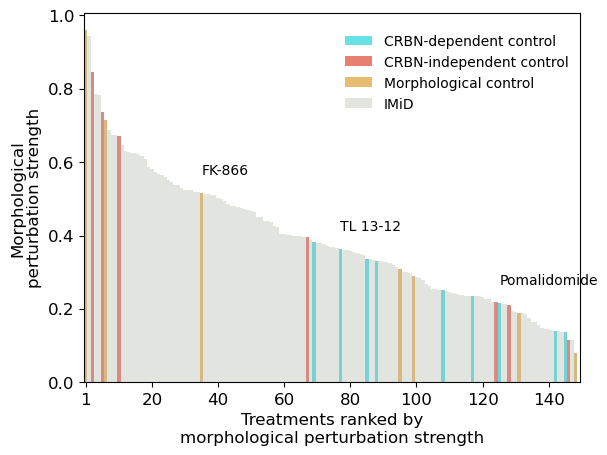

In [8]:
def prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    label2color_dict = label2color_dict,
    output_path = "",
    cpaExamples = cpaExamples,
    controlsOnly = False,
    fontsize = 12
):
    
    # Discard the SuFeX IMiDs if set to controlsOnly == True and set the width of the bars
    width = 1.0
    if controlsOnly == True:
        compoundData = compoundData[compoundData["Label"]!="IMiD"]
        width = 0.4
    
    # Discard DMSO controls since the distance is 0, which would not appear on the distance plot
    compoundData = compoundData[compoundData["Compound"] != "DMSO"]
    
    # Map the categories to their respective colors
    compoundData["color"] = compoundData["Label"].map(label2color_dict)
    
    # Sort the treatmentCalculations by distance in descending order
    compoundData = compoundData.sort_values(by = "Distance", ascending = False).reset_index(drop = True)
    
    # Plot the distances as a barplot
    p = sns.barplot(
        data = compoundData,
        x = compoundData.index + 1,
        y = "Distance",
        width = width,
        palette = compoundData["color"]
    )
    
    # Label the examples
    if len(cpaExamples) > 0:
        for x in compoundData[compoundData["Compound"].isin(cpaExamples)].index:
            plt.annotate(
                text = compoundData.loc[x, "Compound"],
                xy = (x, compoundData.loc[x, "Distance"] + 0.05)
            )

    # Make the x-axis look nicer and set the location of the legend
    new_ticks = [i.get_text() for i in p.get_xticklabels()]
    if controlsOnly != True:
        interval = 20
        bbox_to_anchor = (0.50, 0.70)
    else:
        interval = 5
        bbox_to_anchor = (0.45, 0.72)
    start_index = interval -1
    plt.xticks(range(0, len(new_ticks), interval), [1] + new_ticks[start_index::interval], fontsize = fontsize)
    plt.xlabel("Treatments ranked by\nmorphological perturbation strength", fontsize = fontsize)

    # Make the y-axis look nicer
    plt.yticks(fontsize = fontsize)
    plt.ylabel("Morphological\nperturbation strength", fontsize = fontsize)
        
    # Add the legend
    legend_elements = []
    for label, color in label2color_dict.items():
        if label != "IMiD":
            label = f"{label} control"
        if controlsOnly == True and label == "IMiD":
            continue
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = bbox_to_anchor, ncol = 1, frameon = False,
    )

    # Save the plot if the user has provided an output_path
    savePlot(output_path)    

    # Show the plot
    plt.show()
       
    return
prepFigure()

## 4.2| Profile interpretations using the "treatment-centric" features and data from isogenic RKO cell lines
I developed the "treatment-centric" selection strategy, which selects features that correlate with the CRBN expression of cell lines (see 📜 profile_interpretation_modules.py for more details).

### Distribution of features selected by treatment-centric selection

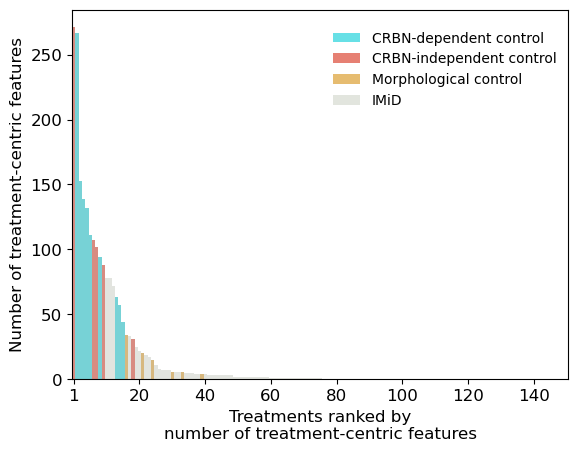

In [9]:
def prepFigure(
    compoundData = pd.read_csv(compoundData_path),
    selectedFeatures = pd.read_csv(selectedFeatures_path),
    label2color_dict = label2color_dict,
    output_path = "",
    cpaExamples = [],
    controlsOnly = False,
    fontsize = 12
):
    # Discard the SuFeX IMiDs if set to controlsOnly == True and set the width of the bars
    width = 1.0
    if controlsOnly == True:
        compoundData = compoundData[compoundData["Label"]!="IMiD"]
        width = 0.4
    
    # Map the categories to their respective colors
    compoundData["color"] = compoundData["Label"].map(label2color_dict)
    
    # Sort the treatmentCalculations by distance in descending order
    compoundData = compoundData.sort_values(by = "Number_Features", ascending = False).reset_index(drop = True)
    
    # Plot the distances as a barplot
    p = sns.barplot(
        data = compoundData,
        x = compoundData.index + 1,
        y = "Number_Features",
        width = width,
        palette = compoundData["color"]
    )
    
    # Label the examples
    if len(cpaExamples) > 0:
        for x in compoundData[compoundData["Compound"].isin(cpaExamples)].index:
            plt.annotate(
                text = compoundData.loc[x, "Compound"],
                xy = (x, compoundData.loc[x, "Number_Features"] + 5)
            )

    # Make the x-axis look nicer and set the location of the legend
    new_ticks = [i.get_text() for i in p.get_xticklabels()]
    if controlsOnly != True:
        interval = 20
        bbox_to_anchor = (0.50, 0.70)
    else:
        interval = 5
        bbox_to_anchor = (0.45, 0.72)
    start_index = interval -1
    plt.xticks(range(0, len(new_ticks), interval), [1] + new_ticks[start_index::interval], fontsize = fontsize)
    plt.xlabel("Treatments ranked by\nnumber of treatment-centric features", fontsize = fontsize)

    # Make the y-axis look nicer
    plt.yticks(fontsize = fontsize)
    plt.ylabel("Number of treatment-centric features", fontsize = fontsize)
        
    # Add the legend
    legend_elements = []
    for label, color in label2color_dict.items():
        if label != "IMiD":
            label = f"{label} control"
        if controlsOnly == True and label == "IMiD":
            continue
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = bbox_to_anchor, ncol = 1, frameon = False,
    )

    # Save the plot if the user has provided an output_path
    savePlot(output_path)    

    # Show the plot
    plt.show()
       
    return
prepFigure()

### Scatterplot: p-value against corrected U scores

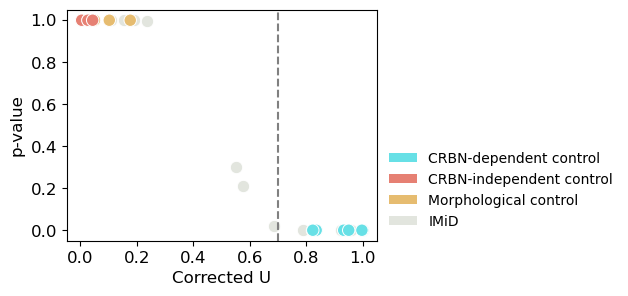

In [24]:
# Isogenic CPA output: p-value versus corrected U
def prepFigure(
    correctedU = pd.read_csv(f"{output_dir}/compoundData.csv"),
    output_path = "",
    x = "Corrected_u", xlabel = "Corrected U",
    y = "p-value", ylabel = "p-value",
    correctedUCutoff = 0.7, cutoffLabelHeight = None,
    numberFeature_threshold = 5,
    pCutoff = None,
    markerSize = 80,
    fontsize = 12,
    label2color_dict = label2color_dict,
    figsize = (4, 3)
):
    # Exclude compounds that have too few treatment-centric features
    correctedU = correctedU[correctedU["Number_Features"] >= numberFeature_threshold].reset_index(drop = True)
    
    # Figure size
    plt.figure(figsize = figsize)
    
    # Plot the SuFEx IMiDs
    p = sns.scatterplot(
        data = correctedU,
        x = x,
        y = y,
        color = label2color_dict["IMiD"],
        s = markerSize
    )
    
    # Plot the controls and color-code them
    hue_order = []
    palette = []
    for label, color in label2color_dict.items():
        hue_order.append(label)
        palette.append(color)
    sns.scatterplot(
        data = correctedU[correctedU["Label"] != "IMiD"],
        x = x,
        y = y,
        hue = "Label",
        hue_order = hue_order,
        palette = palette,
        s = markerSize
    )
    
    # Set the legend
    legend_elements = []
    for label, color in label2color_dict.items():
        if label == "IMiD":
            label = label
        else:
            label = f"{label} control"
        element = Patch(facecolor = color, label = label)
        legend_elements.append(element)
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = (1.0, 0.0), ncol = 1, frameon = False
    )
    
    # X axis aesthetics
    plt.xticks(fontsize = fontsize)
    plt.xlabel(xlabel, fontsize = fontsize)
    
    # Y axis aesthetics
    plt.yticks(fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    
    # Draw a grey dotted line to mark the tentative cutoff on the corrected U (if any)
    if correctedUCutoff != None:
        plt.axvline(x = correctedUCutoff, color = "grey", linestyle = "--")
        if cutoffLabelHeight != None:
            plt.text(
                correctedUCutoff,
                cutoffLabelHeight,
                f"Corrected U = {correctedUCutoff}",
                horizontalalignment = "center",
                color = "grey"
            )
    
    # Draw a grey dotted line to mark the tentative cutoff on the p-value (if any)
    if pCutoff != None:
        plt.axhline(y = pCutoff, color = "grey", linestyle = "--")
        plt.text(
            0.70,
            pCutoff + 0.02,
            f"p-value\ncutoff = {pCutoff}",
            horizontalalignment = "left",
            color = "grey"
        )
    
    # Save the plot
    savePlot(output_path)
    
    # Display the plot
    plt.show()
    return
prepFigure()

### Scatterplot: Number of treatment-centric features against corrected U scores

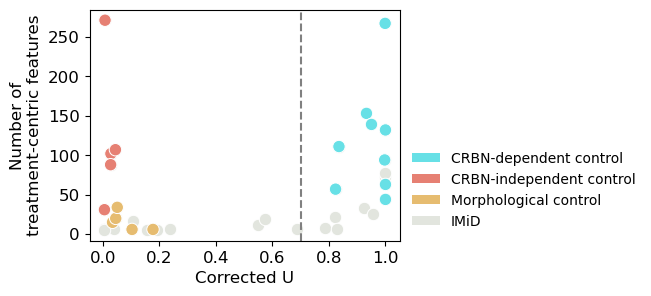

In [29]:
prepFigure(
    x = "Corrected_u", xlabel = "Corrected U",
    y = "Number_Features", ylabel = "Number of\ntreatment-centric features",
    cutoffLabelHeight = None
)

In [141]:
def visualize_inductionScore(
    profile = pd.read_csv(profile_path),
    selectedFeatures = pd.read_csv(selectedFeatures_path),
    featuresSelectedFor = "Pomalidomide",
    compounds = ["Pomalidomide", "Methylated pomalidomide"],
    output_path = "",
    ko = "c1141_rko_ko",
    oe = "c1327_rko_oe",
    colors = ["lightgrey", "#42CDDB"],
    figsize = (7, 5)
):
    # Retrieve the features selected for a specific compound
    print(f"Treatment-centric features selected for: {featuresSelectedFor}")
    selectedFeatures = selectedFeatures[selectedFeatures["Treatment"] == featuresSelectedFor].reset_index(drop = True)
    features = selectedFeatures.loc[0, "Features_Selected"].split(" ")
    if len(features) == 0:
        raise(ValueError(f"The following given treatment has no features selected by the treatment-centric strategy:\n{featuresSelectedFor}"))
      
    # Calculate the induction scores for image in the profile pertaining to the compounds
    inductionScores = []
    profile = profile[profile["Metadata_Cell"].isin([ko, oe])]
    profile = profile[profile["Metadata_Treatment"].isin(compounds)]
    for i in profile.index:
        score = 0
        for feature in features:
            score += abs(profile.loc[i, feature])
        score = score/len(features)
        inductionScores.append(score)
    profile["InductionScore"] = inductionScores
    
    # Calculate the corrected U
    correctedU = compareInduction(profile)
    display(correctedU)
    treatment2u_dict = dict()
    treatment2p_dict = dict()
    for i in correctedU.index:
        treatment = correctedU.loc[i, "Metadata_Treatment"]
        u = correctedU.loc[i, "Corrected_u"]
        p = correctedU.loc[i, "p-value"]
        treatment2u_dict[treatment] = u
        treatment2p_dict[treatment] = p
    
    # Visualize the induction scores for the RKO CRBN KO and RKO CRBN OE only
    plt.figure(figsize = figsize)
    p = sns.violinplot(
        data = profile,
        x = "Metadata_Treatment",
        y = "InductionScore",
        hue = "Metadata_Cell",
        hue_order = [ko, oe],
        palette = colors,
        order = compounds
    )
    
    # Add the plot title
    plt.title(f"Treatment-centric features selected for\n {featuresSelectedFor}")
    
    # Set the plot legend
    legend_elements = [
        Patch(facecolor = colors[0], label = "CRBN KO"),
        Patch(facecolor = colors[1], label = "CRBN OE")
    ]
    p.legend(
        handles = legend_elements,
        loc = "lower left", bbox_to_anchor = (1.0, 0.0), ncol = 1, frameon = False
    )
    
    # Set the y label
    plt.ylabel("Induction score")
    
    # Add the information on the corrected U
    plt.xlabel("")
    plt.xticks([])
    cellText = []
    cellText.append([round(treatment2u_dict[i], 3) for i in compounds])
    cellText.append(["{:.2e}".format(treatment2p_dict[i]) for i in compounds])
    table = plt.table(
        cellText = cellText,
        cellLoc = "center",
        rowLabels = ["Corrected U", "p-value"],
        colLabels = compounds,
        edges = "open",
        bbox = (0.00, -0.20, 1.00, 0.15)
    )
    table.set_fontsize(12)
    
    # Adjust the layout of the plot to make room for the table
    plt.subplots_adjust(left = 0.2, bottom = 0.2)
    
    # Save the plot
    savePlot(output_path)
    
    # Display the plot
    plt.show()
    
    return

#### Compound vs matched CRBN-independent equivalent

Treatment-centric features selected for: Pomalidomide


,Metadata_Treatment,Corrected_u,p-value
0,Pomalidomide,0.835392,1.680885e-10
1,Methylated pomalidomide,0.494722,5.407600e-01


EXPORTED: The plot has been exported at
/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa/cleanPostFeatureExtraction/output_dir/4_DataVisualization_output/treatmentcentric/InductionScore_Violin_comparison1.png


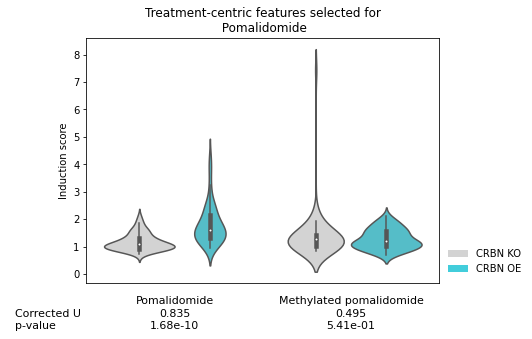

In [150]:
visualize_inductionScore(
    featuresSelectedFor = "Pomalidomide",
    compounds = ["Pomalidomide", "Methylated pomalidomide"],
    output_path = f"{output_dir}/treatmentcentric/InductionScore_Violin_comparison1.png"
)

Treatment-centric features selected for: dBET1


,Metadata_Treatment,Corrected_u,p-value
0,dBET1,1.000000,1.149890e-09
1,MZ1,0.074011,1.000000e+00


EXPORTED: The plot has been exported at
/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa/cleanPostFeatureExtraction/output_dir/4_DataVisualization_output/treatmentcentric/InductionScore_Violin_comparison2.png


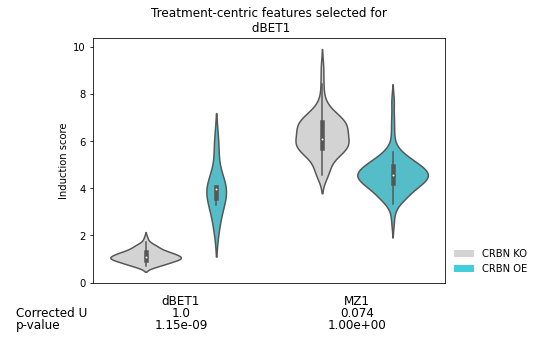

In [147]:
visualize_inductionScore(
    featuresSelectedFor = "dBET1",
    compounds = ["dBET1", "MZ1"],
    output_path = f"{output_dir}/treatmentcentric/InductionScore_Violin_comparison2.png"
)

#### Comparing characterized compounds with similar targets

Treatment-centric features selected for: Pomalidomide


,Metadata_Treatment,Corrected_u,p-value
0,Lenalidomide,0.875556,6.536427e-13
1,Pomalidomide,0.835392,1.680885e-10
2,DMSO,0.477886,8.478466e-01
3,Avadomide,0.761944,3.771356e-07
4,Iberdomide,0.927222,3.521185e-16


EXPORTED: The plot has been exported at
/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa/cleanPostFeatureExtraction/output_dir/4_DataVisualization_output/treatmentcentric/InductionScore_Violin_comparison3.png


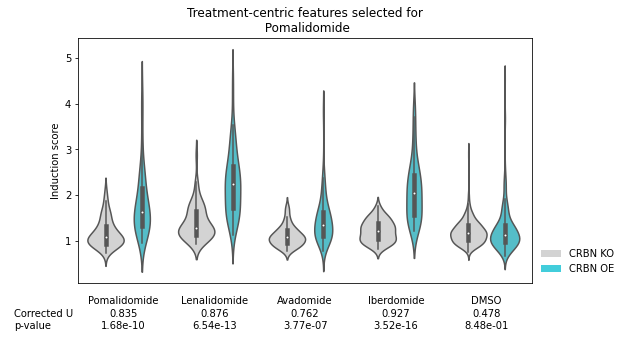

In [153]:
visualize_inductionScore(
    featuresSelectedFor = "Pomalidomide",
    compounds = ["Pomalidomide", "Lenalidomide", "Avadomide", "Iberdomide", "DMSO"],
    output_path = f"{output_dir}/treatmentcentric/InductionScore_Violin_comparison3.png",
    figsize = (9, 5)
)

Treatment-centric features selected for: dBET1


,Metadata_Treatment,Corrected_u,p-value
0,dBET1,1.000000,1.149890e-09
1,dBET6,1.000000,1.100609e-08
2,DMSO,0.494869,5.942491e-01


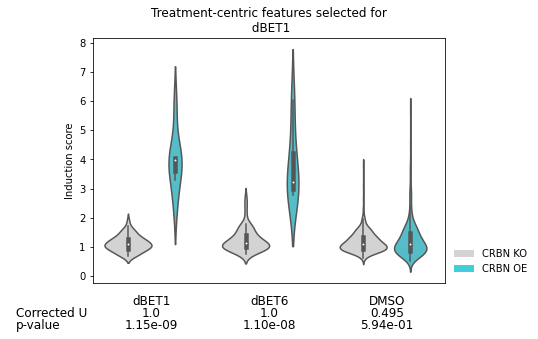

In [154]:
visualize_inductionScore(
    featuresSelectedFor = "dBET1",
    compounds = ["dBET1", "dBET6", "DMSO"],
    output_path = ""
)

### Scatterplot: Morphological perturbation strength against corrected U

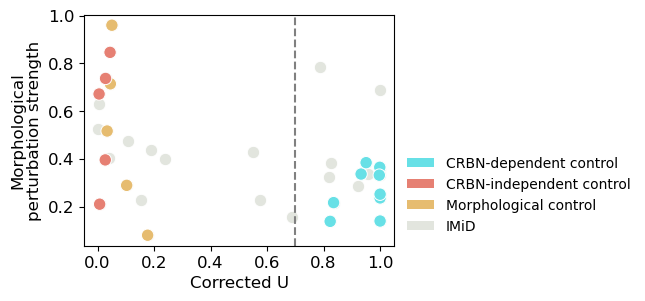

In [26]:
prepFigure(
    x = "Corrected_u", xlabel = "Corrected U",
    y = "Distance", ylabel = "Morphological\nperturbation strength",
    cutoffLabelHeight = None
)

### Scatterplot: CRBN binding affinity against corrected U

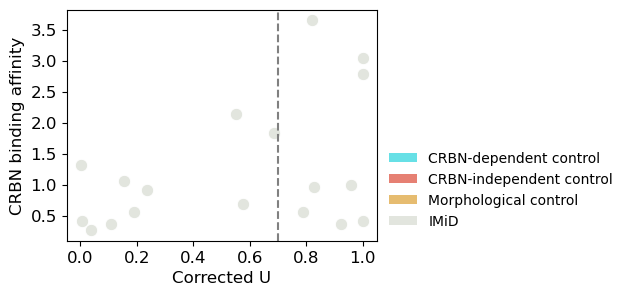

In [28]:
prepFigure(
    x = "Corrected_u", xlabel = "Corrected U",
    y = "FP_CRBN_binding", ylabel = "CRBN binding affinity",
    cutoffLabelHeight = None
)

### Example: Viewing the induction scores as a violin plot for TL 13-12

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

c1141_rko_ko vs. c1327_rko_oe: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.380e-21 U_stat=4.000e+00


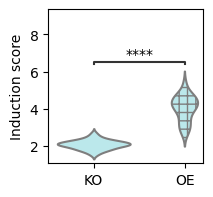

In [6]:
def prepFigure(
    inductionScores = pd.read_csv(inductionScores_path),
    compound = "TL 13-12",
    output_path = "",
    pair = ["c1141_rko_ko", "c1327_rko_oe"],
    pairLabels = ["KO", "OE"],
    figsize = (2, 2),
    hatch = [None, "++"],
    color = adjust_colorLuminosity(label2color_dict["CRBN-dependent"], 0.5),
    xlim = (-0.5, 1.2)
):
    # Trim down the inductionScores to those pertaining to the compound
    inductionScores = inductionScores[inductionScores["Metadata_Treatment"] == compound]
    
    # Retrieve the scores corresponding to RKO CRBN KO
    ko_scores = inductionScores[inductionScores["Metadata_Cell"] == "c1141_rko_ko"]["InductionScore"]

    # Retrieve the scores corresponding to RKO CRBN OE
    oe_scores = inductionScores[inductionScores["Metadata_Cell"] == "c1327_rko_oe"]["InductionScore"]
        
    # Define the plotting parameters to use for both the violinplot and the annotator calls
    plotting_parameters = {
        "data" : inductionScores,
        "x" : "Metadata_Cell",
        "y" : "InductionScore",
        "color" : color,
        "order" : pair
    }
    
    # Define the pair of data to compare
    pairs = [tuple(pair)]
    
    # Set the size of the figure
    if figsize != "Default":
        plt.figure(figsize = (figsize))

    # Seaborn violinplot
    p = sns.violinplot(
        **plotting_parameters,
        inner = None
    )
    ihatch = iter(hatch)
    _ = [i.set_hatch(next(ihatch)) for i in p.get_children() if isinstance(i, collections.PolyCollection)]

    # Add the annotations
    annotator = Annotator(
        p,
        pairs,
        plot = "violinplot",
        **plotting_parameters
    )
    annotator.configure(
        test = "Mann-Whitney",
        comparisons_correction = "bonferroni",
        text_format = "star",
        loc = "outside"
    )
    annotator.apply_and_annotate()

    # X axis aesthetics
    plt.xticks(ticks = [0, 1], labels = pairLabels)
    xmin, xmax = p.get_xlim()
    plt.xlim(*xlim)
    plt.xlabel("")

    # Y axis aesthetics
    ymin, ymax = p.get_ylim()
    plt.ylim(None, ymax*1.5)
    plt.ylabel("Induction score")

    # Export the plot
    savePlot(output_path)

    # Show the plot
    plt.show()
    
    return
prepFigure()

### Force-directed network graph: Comparing the treatment-centric features of compounds

In [11]:
def test(
    selectedFeatures = pd.read_csv(selectedFeatures_path),
    tauValues = pd.read_csv(tauOutput_path),
    compoundData_path = compoundData_path,
    output_path = f"{output_dir}/cosineSimilarity.csv"
):
    """
    Function for quantifying the pairwise similarities of the treatment-centric features of compounds
    predicted to have CRBN-dependent bioactivity (number of treatment-centric features >= 5, corrected
    U >= 0.7). The first part consists of renaming the CRBN binders so that it matches the manuscript
    and the second part uses the actual function for the quantification. The quantification is done
    using the cosine similarity metric.

    :param selectedFeatures: Dataframe with the features selected using different strategies.
    :type selectedFeatures: pd.DataFrame
    :param tauValues: Dataframe with the tau values calculated during treatment-centric feature
        selection. The tau values loosely reflect the strength and type of correlation (positive or
        negative) between the change in a given feature and the expression of CRBN (or another protein)
        across the isogenic cell lines used.
    :type tauValues: pd.DataFrame
    :param compoundData_path: Full path to the dataframe with calculations/data for each compound
    (Corrected U scores and number of treatment-centric features required).
    :type compoundData: pd.DataFrame
    :param output_path: Path to export the dataframe of cosine similarity values to.
    :type output_path: str
    """
    #############################################################################
    # Rename the CRBN binders in the selectedFeatures_path and the tauOutput_path
    #############################################################################
    # Dictionary for mapping the original fluorosulfate scaffold name to the new name
    old2newScaffold_dict = {
        "B" : "FL1",
        "D" : "FL2",
        "F" : "FL3",
        "H" : "FL4",
        "C" : "FL5",
        "E" : "FL6"
    }

    # Update the names in the selectedFeatures and tauValues
    renamed_df_list = []
    for df, column in zip(
        [selectedFeatures, tauValues],
        ["Treatment", "Metadata_Treatment"]
    ):
        for i in df.index:
            compound = df.loc[i, column]
            if len(compound) in [2, 3] and compound[0] in old2newScaffold_dict:
                scaffold = compound[0]
                tailGroup = compound[1:]
                newScaffold = old2newScaffold_dict[scaffold]
                compound = f"{newScaffold}-{tailGroup}"
            df.loc[i, column] = compound
        renamed_df_list.append(df)

    #################################################################################################
    # Calculate the cosine similarities of tau values for treatment-centric features for all pairs of
    # compounds that have a corrected U score of >= 0.7 and at least 5 treatment-centric features
    #################################################################################################
    cosine_df = calculate_cosineSimilarity(
        selectedFeatures = renamed_df_list[0],
        tauValues = renamed_df_list[1],
        compoundData = pd.read_csv(compoundData_path),
        output_path = output_path,
        correctedU_threshold = 0.7,
        featureNumber_threshold = 5
    )
                
    return(cosine_df)

cosine_df = test()

# Have a look at the cosine similarities
cosine_df

EXPORTED: Pairwise cosine similarities between tau values of treatment-centric features has been calculated and exported at:/n/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa/cleanPostFeatureExtraction/output_dir/4_ProfileInterpretation_output/cosineSimilarity.csv


,dBET1,Avadomide,FL1-18,CC-90009,Pomalidomide,CC-885,FL1-2,FL4-2,FL4-6,dBET6,FL2-14,FL6-6,Iberdomide,FL1-12,FL1-6,Lenalidomide,TL 13-12
dBET1,1.0,-0.062581,0.636511,0.8662,0.356415,0.808317,0.565888,0.426981,0.079706,0.915383,0.468449,-0.058741,0.455232,0.553289,0.68563,0.477669,0.543142
Avadomide,-0.062581,1.0,-0.36644,-0.27613,0.861959,-0.384018,-0.47169,0.646863,0.571876,-0.107897,0.053011,-0.260575,0.480631,-0.274187,-0.034966,0.09398,-0.166601
FL1-18,0.636511,-0.36644,1.0,0.896998,-0.026192,0.933002,0.931628,-0.169751,-0.593286,0.744885,0.864715,0.517926,0.206487,0.964441,0.780743,0.17973,0.619421
CC-90009,0.8662,-0.27613,0.896998,1.0,0.105754,0.957125,0.833691,0.211852,-0.042999,0.924637,0.817251,0.374775,0.366034,0.852774,0.799217,0.371792,0.719769
Pomalidomide,0.356415,0.861959,-0.026192,0.105754,1.0,-0.042774,-0.226386,0.853705,0.569002,0.184224,0.240973,-0.37597,0.864552,-0.020435,0.261943,0.646758,0.052014
CC-885,0.808317,-0.384018,0.933002,0.957125,-0.042774,1.0,0.898831,0.020642,-0.39166,0.910503,0.782558,0.463259,0.239874,0.89747,0.806027,0.284655,0.742565
FL1-2,0.565888,-0.47169,0.931628,0.833691,-0.226386,0.898831,1.0,-0.350393,-0.534406,0.695687,0.734281,0.566224,0.068955,0.914583,0.711146,0.168508,0.672555
FL4-2,0.426981,0.646863,-0.169751,0.211852,0.853705,0.020642,-0.350393,1.0,0.736193,0.248188,0.235827,-0.899763,0.83225,-0.328492,0.391451,0.713396,0.284029
FL4-6,0.079706,0.571876,-0.593286,-0.042999,0.569002,-0.39166,-0.534406,0.736193,1.0,-0.107956,-0.34605,-0.647547,0.272893,-0.625519,-0.049395,0.31092,0.036555
dBET6,0.915383,-0.107897,0.744885,0.924637,0.184224,0.910503,0.695687,0.248188,-0.107956,1.0,0.680975,0.32903,0.381409,0.729541,0.783517,0.352765,0.627983


In [18]:
# Function for visualizing all cosine similarities as a network
# Note: The layout of the network is set to spring_layout which I have found to be the best
# for visualizing separate bioactivity groups. This layout format may not be able to cope with
# very large datasets.
def visualizeAs_network(
    cosine_df,
    correctedU_threshold,
    featureNumber_threshold,
    highlightCompounds = [], # names of the compounds to highlight
    highlightColor = "black",
    controls = [], # names of the controls
    cosine_threshold = 0.85,
    showNodeLabels = True,
    output_path = "",
    marginSpace_xy = (0.0, 0.0), # squeeze the network to ensure all labels can be seen
    springLayout_seed = 500,
    footnote_position = (0.01, 0.01),
    showFootnote = True,
    label2color_dict = label2color_dict
):
    """
    Visualize the cosine similarities calculated for all pairs of compounds as a force-directed network
    graph (i.e. the spring layout using NetworkX).

    :param cosine_df: Dataframe of cosine similarity values calculated.
    :type cosine_df: pd.DataFrame
    :param correctedU_threshold: Minimum corrected U score for a compound to be predicted as having
        bioactivity dependent on an effector protein of interest.
    :type correctedU_threshold: float (can be from 0 to 1)
    :param featureNumber_threshold: Minimum number of treatment-centric features for a compound to have
        a reliable corrected U score. In theory, a higher number should reflect higher reliability.
    :type featureNumber_threshold: int
    :param highlightCompounds: List of compounds to highlight in the network graph by changing the
        border color of the compounds' node.
    :type highlightCompounds: list
    :param highlightColor: Color to use for the border of nodes of compounds to highlight.
    :type highlightColor: str
    :param controls: List of compound names corresponding to the CRBN-dependent controls.
    :type controls: list
    :param cosine_threshold: The minimum cosine similarity score for the edge between two nodes to be
        thick, representing that two nodes (compounds) have similar treatment-centric features.
    :param showNodeLabels: Option to show the labels of the nodes. Defaults to True.
    :type showNodeLabels: bool
    :param output_path: Path to export the network graph to. Defaults to "" which means the network
        graph is NOT exported.
    :type output_path: str
    :param marginSpace_xy: The amount of margin space to give. Adjusting the (x, y) values helps with
        ensuring that all labels/nodes of the network graph are fully visible. Defaults to (0.0, 0.0).
    :type marginSpace_xy: tuple
    :param springLayout_seed: Number of seeds to use for generating the force directed graph. Defaults
        to 500.
    :type springLayout_seed: int
    :param footnote_position: The position of the footnote (if any) on the network graph. Defaults to
        (0.01, 0.01).
    :type footnote_position: tuple
    :param showFootnote: Option to show the footnote that describes the threshold and network layout
        used. Defaults to True.
    :type showFootnote: bool
    :param label2color_dict: Dictionary for color-coding the nodes by their label.
    :type label2color_dict: dict
    """
    ####################################################################
    # Plot all the compounds as nodes
    # and cosine similarities as edges if they pass the cosine_threshold
    ####################################################################
    # Initialize an empty graph
    G = nx.Graph()
    
    #  Add the compounds as nodes
    for treatment in cosine_df.index:
        if treatment in controls:
            color = label2color_dict["CRBN-dependent"]
        else:
            color = label2color_dict["CRBN binder"]
        G.add_node(treatment, node_color = color)
        
    # Add the edges
    treatmentsWithEdgesAdded = []
    for treatment_a in cosine_df.index:
        treatmentsWithEdgesAdded.append(treatment_a)
        for treatment_b in cosine_df.columns:
            if treatment_b not in treatmentsWithEdgesAdded:
                cosine = cosine_df.loc[treatment_a, treatment_b]
                if cosine >= cosine_threshold:
                    if treatment_a in controls or treatment_b in controls:
                        passColor = label2color_dict["CRBN-dependent"]
                    else:
                        passColor = "black"
                    edgeAesthetics = {
                        "color" : passColor,
                        "weight" : 3
                    }
                else:
                    edgeAesthetics = {
                        "color" : "lightgrey",
                        "weight" : 0.2
                    }
                G.add_edge(
                    treatment_a,
                    treatment_b,
                    color = edgeAesthetics["color"],
                    weight = edgeAesthetics["weight"]
                )
    
    #################################################################################
    # Draw the graph and export it if the use has provided the output_path
    # Note: Increasing the number of seeds improves how spaced out the nodes can be
    # which can be useful when you have more compounds/nodes
    #################################################################################
    pos = nx.spring_layout(G, iterations = 200, seed = springLayout_seed)
    nodeColors = list(nx.get_node_attributes(G, "node_color").values())
    colors = nx.get_edge_attributes(G, "color").values()
    weights = nx.get_edge_attributes(G,"weight").values()
    nx.draw(
        G,
        pos,
        with_labels = showNodeLabels,
        font_size = 10,
        node_color = nodeColors,
        edge_color = colors,
        width = list(weights),
        node_size = 1600,
        # bbox = {
        #     "facecolor" : "white",
        #     "alpha" : 0.5,
        #     "linewidth" : 0
        # }
    )
    
    # Highlight compounds if any
    nodeColors_subset = []
    for color, node in zip(nodeColors, list(pos.keys())):
        if node in highlightCompounds:
            nodeColors_subset.append(color)
    if len(highlightCompounds) > 0:
        nx.draw_networkx_nodes(
            G,
            pos, nodelist = highlightCompounds,
            node_color = nodeColors_subset,
            node_size = 1620,
            linewidths = 5,
            edgecolors = highlightColor
        )
    
    # Squeeze the network graph to fit the margins and make space for the labels
    # either horizontally (increase x)
    # or vertically (increse y)
    x, y = marginSpace_xy
    plt.margins(x = x, y = y)
    
    # Add footnote describing the settings used
    footnote = f"""Network layout: spring
Minimum number of treatment-centric features: {featureNumber_threshold}
Minimum corrected U score: {correctedU_threshold}
Cosine similarity threshold: {cosine_threshold}
    """
    x, y = footnote_position
    if showFootnote == True:
        plt.figtext(x, y, footnote, ha = "left")
    else:
        print(footnote)
    
    # Save the plot if the user has provided the output_path
    savePlot(output_path)
    
    return

Network layout: spring
Minimum number of treatment-centric features: 5
Minimum corrected U score: 0.7
Cosine similarity threshold: 0.85
    
EXPORTED: The plot has been exported at
/research/lab_winter/users/ang/projects/GW015_SuFEX_IMiDs/GW015_006__full_cpa/cleanPostFeatureExtraction/output_dir/4_ProfileInterpretation_output/networkGraph.png


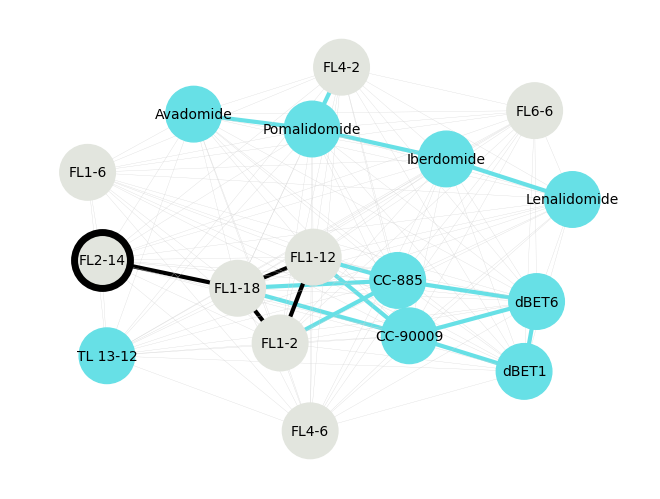

In [19]:
visualizeAs_network(
    cosine_df = cosine_df,
    correctedU_threshold = 0.7,
    featureNumber_threshold = 5,
    highlightCompounds = ["FL2-14"],
    controls = [
        "Pomalidomide", "Iberdomide", "Lenalidomide", "Avadomide",
        "dBET1", "dBET6", "CC-885", "CC-90009", "TL 13-12"
    ],
    cosine_threshold = 0.85,
    output_path = f"{output_dir}/networkGraph.png",
    marginSpace_xy = (0.1, 0.1),
    footnote_position = (0.01, 0.01),
    showFootnote = False
)